In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout, Input, Lambda, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
import os
import cv2
import random
from sklearn.model_selection import train_test_split

In [2]:
# Define directories
train_dir = 'Dataset/pest/train'
test_dir = 'Dataset/pest/test'

# Function to create image pairs for Siamese network
def create_pairs(images_by_class, num_pairs_per_class=100):
    pairs = []
    labels = []
    
    # Same class pairs (label=1)
    for class_images in images_by_class.values():
        if len(class_images) < 2:
            continue
            
        for _ in range(num_pairs_per_class):
            # Randomly select two images from the same class
            idx1, idx2 = random.sample(range(len(class_images)), 2)
            pairs.append([class_images[idx1], class_images[idx2]])
            labels.append(1)  # 1 indicates same class
    
    # Different class pairs (label=0)
    classes = list(images_by_class.keys())
    for _ in range(num_pairs_per_class * len(classes)):
        # Select two different classes
        class1, class2 = random.sample(classes, 2)
        
        # Select random images from these classes
        img1 = random.choice(images_by_class[class1])
        img2 = random.choice(images_by_class[class2])
        
        pairs.append([img1, img2])
        labels.append(0)  # 0 indicates different classes
    
    return np.array(pairs), np.array(labels)

In [3]:
# Function to load and preprocess all images from a directory
def load_images_from_directory(directory):
    images_by_class = {}
    class_indices = {}
    
    # Get all subdirectories (classes)
    classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    
    for i, class_name in enumerate(classes):
        class_indices[class_name] = i
        class_dir = os.path.join(directory, class_name)
        images_by_class[class_name] = []
        
        # Get all image files
        image_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        for img_file in image_files:
            img_path = os.path.join(class_dir, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
                
            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0  # Normalize to [0, 1]
            images_by_class[class_name].append(img)
            
    return images_by_class, class_indices

In [4]:
# Euclidean distance function for Siamese network
def euclidean_distance(vectors):
    x, y = vectors
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


In [5]:
# Build Siamese network base
def build_siamese_base():
    base_model = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3)
    ])
    return base_model

In [6]:
# Build Siamese model
def build_siamese_model():
    base_network = build_siamese_base()
    
    input_a = Input(shape=(224, 224, 3))
    input_b = Input(shape=(224, 224, 3))
    
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    
    distance = Lambda(euclidean_distance)([processed_a, processed_b])
    output = Dense(1, activation='sigmoid')(distance)
    
    siamese_model = Model(inputs=[input_a, input_b], outputs=output)
    siamese_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return siamese_model

In [7]:
# Function to process pairs for model input
def prepare_pairs_for_model(pairs):
    left_input = []
    right_input = []
    
    for pair in pairs:
        left_input.append(pair[0])
        right_input.append(pair[1])
        
    return [np.array(left_input), np.array(right_input)]


In [8]:
# Main training function
def train_siamese_model():
    # Load and preprocess images
    print("Loading training images...")
    train_images_by_class, class_indices = load_images_from_directory(train_dir)
    print(f"Found {len(class_indices)} classes")
    
    # Create pairs for training
    print("Creating image pairs for training...")
    pairs, labels = create_pairs(train_images_by_class)
    
    # Split data into train and validation sets
    train_pairs, val_pairs, train_labels, val_labels = train_test_split(
        pairs, labels, test_size=0.2, random_state=42
    )
    
    # Prepare data for model
    train_pair_data = prepare_pairs_for_model(train_pairs)
    val_pair_data = prepare_pairs_for_model(val_pairs)
    
    # Build and train the model
    print("Building and training Siamese model...")
    siamese_model = build_siamese_model()
    
    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    
    # Train the model
    history = siamese_model.fit(
        train_pair_data, train_labels,
        validation_data=(val_pair_data, val_labels),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr]
    )
    
    # Save the model
    siamese_model.save("siamese_model.h5")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.savefig('siamese_training_history.png')
    plt.show()
    
    # Load and preprocess test images for evaluation
    print("\nLoading test images for evaluation...")
    test_images_by_class, _ = load_images_from_directory(test_dir)
    
    # Create pairs for testing
    print("Creating image pairs for testing...")
    test_pairs, test_labels = create_pairs(test_images_by_class, num_pairs_per_class=50)
    test_pair_data = prepare_pairs_for_model(test_pairs)
    
    # Evaluate the model
    print("\nEvaluating model on test data...")
    test_loss, test_acc = siamese_model.evaluate(test_pair_data, test_labels)
    print(f"Test accuracy: {test_acc:.4f}")
    
    # Return model and accuracy
    return siamese_model, test_acc, class_indices


In [9]:
# Inference function for using the Siamese network for classification
def classify_with_siamese(siamese_model, reference_images_by_class, test_image, threshold=0.5):
    results = {}
    
    # For each class, compare the test image with all reference images
    for class_name, ref_images in reference_images_by_class.items():
        similarities = []
        
        for ref_img in ref_images:
            # Prepare the pair
            pair = prepare_pairs_for_model([[test_image, ref_img]])
            
            # Get similarity prediction (1 = same class, 0 = different class)
            similarity = siamese_model.predict(pair)[0][0]
            similarities.append(similarity)
        
        # Average similarity for this class
        avg_similarity = np.mean(similarities)
        results[class_name] = avg_similarity
    
    # Find the class with highest similarity
    predicted_class = max(results, key=results.get)
    confidence = results[predicted_class]
    
    # Only classify if confidence is above threshold
    if confidence > threshold:
        return predicted_class, results
    else:
        return "Unknown", results

Loading training images...
Found 9 classes
Creating image pairs for training...
Building and training Siamese model...


c:\Hemanth\Mini Project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 930ms/step - accuracy: 0.4918 - loss: 0.9772 - val_accuracy: 0.5028 - val_loss: 0.9566 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5018 - loss: 0.8481 - val_accuracy: 0.5028 - val_loss: 0.8085 - learning_rate: 0.0010
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.5066 - loss: 0.7738 - val_accuracy: 0.5056 - val_loss: 0.7437 - learning_rate: 0.0010
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4960 - loss: 0.7282 - val_accuracy: 0.4944 - val_loss: 0.7128 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5123 - loss: 0.7017 - val_accuracy: 0.5194 - val_loss: 0.7007 - learning_rate: 0.0010
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5121 - loss: 0.6956 - val_accuracy: 0.4694 - val_loss: 0.6982 - learning_rate: 0.0010
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5211 - loss: 0.6904 - val_accura

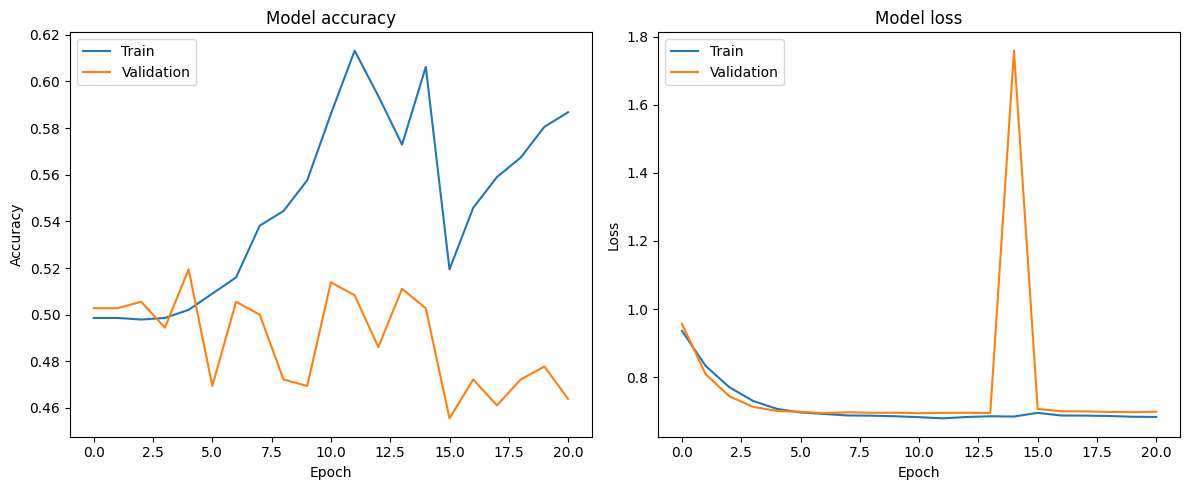


Loading test images for evaluation...
Creating image pairs for testing...

Evaluating model on test data...
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.3636 - loss: 0.7088
Test accuracy: 0.5111
Siamese Network Test Accuracy: 51.11%


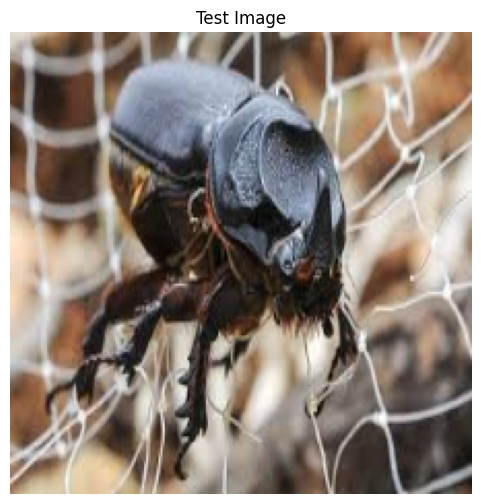

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━

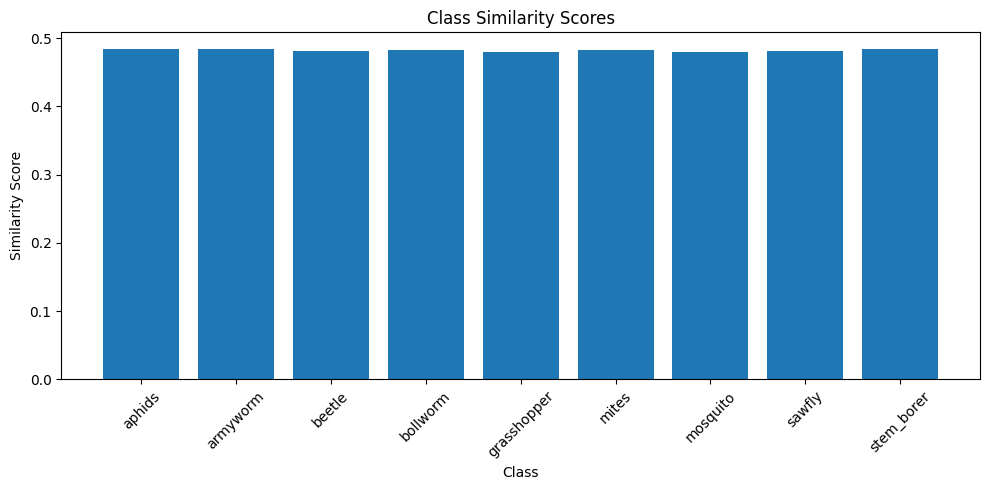

In [10]:
# Example of how to run the entire process
if __name__ == "__main__":
    # Train the Siamese model
    siamese_model, test_accuracy, class_indices = train_siamese_model()
    print(f"Siamese Network Test Accuracy: {test_accuracy * 100:.2f}%")
    
    # Save class indices for later use
    with open('class_indices.txt', 'w') as f:
        for class_name, idx in class_indices.items():
            f.write(f"{class_name}: {idx}\n")
    
    # Test on a single image
    img_test_path = 'Dataset/pest/test/beetle/jpg_33.jpg'
    if os.path.exists(img_test_path):
        # Load and preprocess the test image
        img = cv2.imread(img_test_path)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
        
        # Display the test image
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title("Test Image")
        plt.axis('off')
        plt.show()
        
        # Load reference images for classification
        reference_images_by_class, _ = load_images_from_directory(train_dir)
        
        # Classify the test image
        predicted_class, class_similarities = classify_with_siamese(
            siamese_model, reference_images_by_class, img
        )
        
        print(f"Predicted Class: {predicted_class}")
        
        # Plot class similarities
        plt.figure(figsize=(10, 5))
        classes = list(class_similarities.keys())
        similarities = list(class_similarities.values())
        
        plt.bar(classes, similarities)
        plt.xlabel("Class")
        plt.ylabel("Similarity Score")
        plt.title("Class Similarity Scores")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('class_similarities.png')
        plt.show()
    else:
        print(f"Warning: Test image path {img_test_path} not found.")